# Lijst

1. Boven, tijd,positie,stof-type -geindexeerde dataframes.

2. Lager [Clustering](#Clustering,-zonder-expliet-gebruikt-positie), die succesvol verschillende
  gebieden lijkt te scheiden.

3. Nog een [keer afvragen wat interessant](#Nog-een-keer...-welke-stoffen-interessant?).

   &rArr; aantal stoffen, en locaties om land via die clustering.
   
   `../data/intermediate/land_loc.csv` is een lijst van die locaties.

4. Met clustering [jaarlijkse patronen](#Yearlies?)
----

In [1]:
import pandas as pd

par_par   = ['PAR', 'EHD', 'WAARDE']
point_par = ['LOC', 'PLT:X', 'PLT:Y', 'DATUM:TIJD']

df = pd.read_csv("../data/intermediate/rest.csv", parse_dates=['DATUM:TIJD'],
                       usecols=par_par + point_par + ['CPM'], engine='c')

In [2]:
df = pd.read_csv("../data/intermediate/rest.csv", parse_dates=['DATUM:TIJD'])

In [3]:
import pandas as pd

# read data
path = '../data/data_tot.csv'

par_par   = ['PAR', 'EHD', 'WAARDE']
point_par = ['LOC', 'PLT:X', 'PLT:Y', 'DATUM:TIJD']

columns = par_par + point_par[:-1] + ['DATUM', 'TIJD', 'CPM']

omschrijvingen = ['ID', 'LOCOMS', 'ORGOMS', 'BTXCOD', 'BTXOMS',
                  'GBDOMS', 'OGIOMS', 'ANIOMS', 'BHIOMS',
                  'BMIOMS', 'VATOMS']

df = pd.read_csv(path, encoding='latin1', usecols=columns, engine='c')

def lookup(s):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.apply(lambda v: dates[v])

df.insert(0, 'DATUM:TIJD', lookup(df.DATUM + df.TIJD))
df.drop(['DATUM', 'TIJD'], axis=1, inplace=True)

In [4]:
import numpy as np

def combine_interests(df, interests, val='WAARDE', loc=['LOC', 'PLT:X', 'PLT:Y', 'DATUM:TIJD'], de_unit=True):
    gen = ([l, [cdf[(cdf.PAR==par) & (cdf.EHD==ehd)][val] for par,ehd in interests]]
            for l,cdf in df.groupby(loc))
    return pd.DataFrame([[*list(l), *[(next(iter(v)) if len(v)>0 else np.nan) for v in vs]]for l,vs in gen],
                        columns = loc + (interests if not de_unit else [n for n,u in interests]))
    #for l, cdf in gen:

In [5]:
pdf = combine_interests(df, [('ZS', 'mg/l'), ('GR','mg/l'), ('RESTB', 'mBq/l')])

In [6]:
pdf[~pdf.ZS.isna() & ~pdf.RESTB.isna() & (pdf.LOC=='BOVSS')].plot('DATUM:TIJD', ['ZS', 'RESTB'], figsize=(14,7), style='.-')

/home/jasper/.local/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


/home/jasper/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


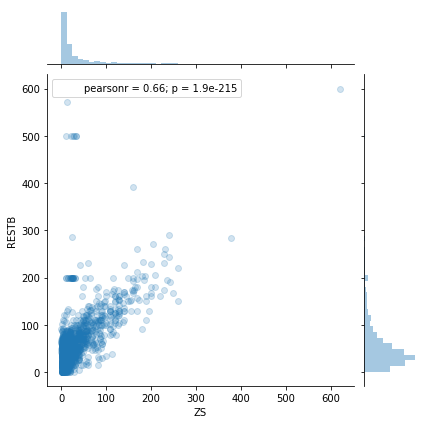

In [7]:
import seaborn as sns
sns.jointplot(pdf.ZS, pdf.RESTB, alpha=0.2)

In [8]:
pdf2 = combine_interests(df, [('ZS', 'mg/l'), ('GR','mg/l'), ('WINDSHD', 'm/s'), ('WINDRTG', 'graad'), ('SALNTT','DIMSLS')])

/home/jasper/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


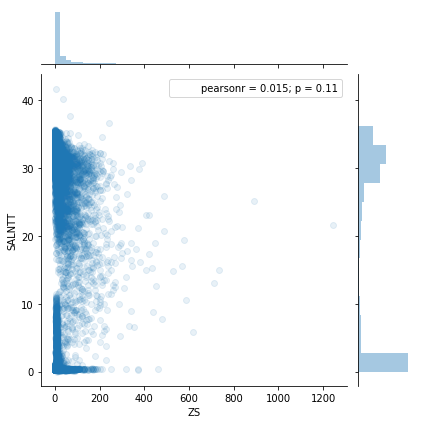

In [9]:
sel = pdf2[pdf2.SALNTT<100]
sns.jointplot(sel.ZS, sel.SALNTT, alpha=0.1)

## Gelijksoortig patroon voor `ZS` voor zoeter/zouter water.
(merk op niet genormalizeerde plot)

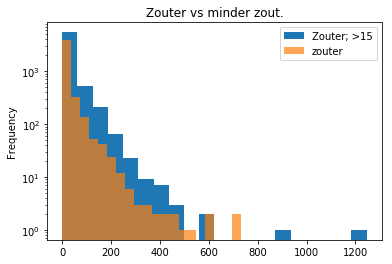

In [10]:
ax = pdf2[pdf2.SALNTT>15].plot.hist(y='ZS', bins=20, logy=True, label='Zouter; >15', title="Zouter vs minder zout.")
pdf2[pdf2.SALNTT<=15].plot.hist(y='ZS', bins=20, ax=ax, alpha=0.7, label='zouter')

# Gerelateerde waarden
[Zwevende ](http://www.natuurlexicon.be/zwevendestoffen.html)

Oorzaken
* Golfhoogte `GOLFHTE`
* Schuim, Vuil (weinig punten tegelijk met.)
* Debiet `Ql` (grotere rivier, minder turbulentie per debiet)

ZS &RArr;
* Minder transparant


---
* hardheid `HHTTL`
* geleidendheid `GELDHD`


In [11]:
df[df.PAR=='GELDHD'].EHD.unique()

array(['mS/m'], dtype=object)

In [12]:
paru =  [('ZS', 'mg/l'), ('GR','mg/l'), ('WINDSHD', 'm/s'), ('WINDRTG', 'graad'), ('SALNTT','DIMSLS'),
         ('GOLFHTE','dm'), ('Ql', 'l'),
         # ('SCHUIM', 'DIMSLS'), ('VUIL', 'DIMSLS'), # Weinig in combinatie.
         ('ZICHT','dm'), ('HHTTL','mg/l'),
         ('GELDHD', 'mS/m')
        ]
pdf3 = combine_interests(df, paru)

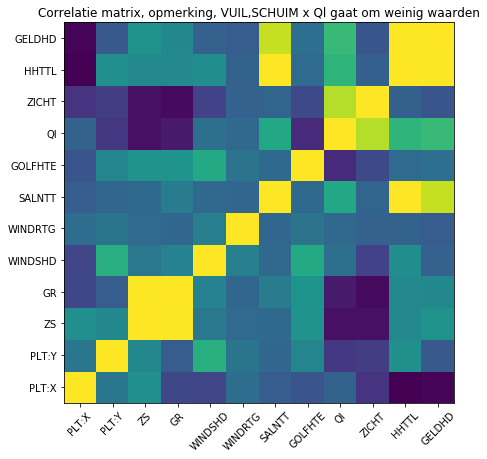

In [13]:
c = pdf3.corr()

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, figsize=(7,7))
ax.pcolor(np.array([[c[k][i] for i in c.index] for k in c.keys()]))

ax.set_title("Correlatie matrix, opmerking, VUIL,SCHUIM x Ql gaat om weinig waarden")
ax.set_xticks([i +0.5 for i,n in enumerate(c.index)])
ax.set_yticks([i +0.5 for i,n in enumerate(c.index)])
ax.set_xticklabels(c.index, rotation=45)
ax.set_yticklabels(c.index)
None

/home/jasper/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


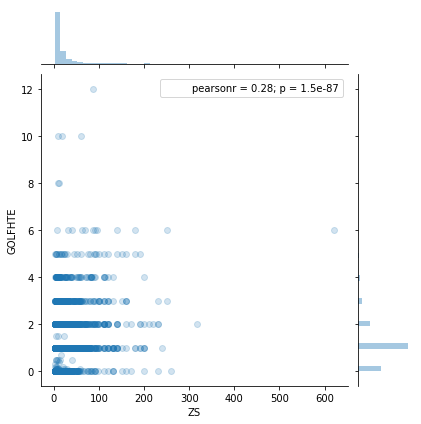

In [14]:
sns.jointplot(pdf3.ZS, pdf3.GOLFHTE, alpha=0.2)

/home/jasper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


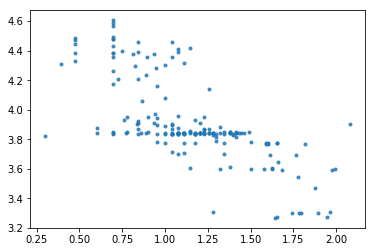

In [15]:
plt.plot(np.log10(pdf3.ZS), np.log10(pdf3.Ql), '.', alpha=0.8)

# Veroorzaakt door ZS

/home/jasper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


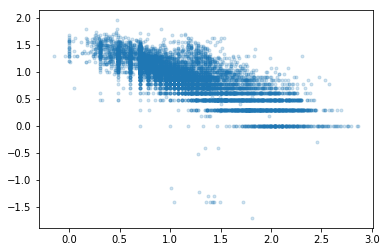

In [16]:
plt.plot(np.log10(pdf3.ZS), np.log10(pdf3.ZICHT), '.', alpha=0.2)

# Clustering, zonder expliet gebruikt positie

In [17]:
gb = df.groupby(['LOC','PLT:X','PLT:Y', 'PAR','EHD'])
m = gb.mean().drop('CPM', axis=1).rename({'WAARDE':'mean'}, axis=1)

m['median'] = gb.median().WAARDE
m['var']    = gb.var().WAARDE
m['what']   = [el[-2:] for el in m.index]
m.index = [el[:-2] for el in m.index]

m_key = m.what.unique()
m_rename = {(p,u):(p if sum(1 for p2,u2 in m_key if p2==p)==1 else (p,u)) for p,u in m_key}
m.what = [m_rename[val] for val in m.what]

In [18]:
from sklearn import cluster
import numpy as np

`m_pivoted` heeft de clustering resultaten niet, zodat kmeans dbscan niet vervuilt en ook niet andersom.

In [19]:
m_pivoted = m.pivot(None, 'what')
m_cluster  = m_pivoted['mean'].join(m_pivoted['var'], lsuffix='_var')

In [20]:
# NOTE m_cluster different thing, so shouldnt be fouling itself?
import math

kmeans = cluster.KMeans(n_clusters=4)
dbscan = cluster.DBSCAN(eps=50)

m_pivoted['kmeans'] = kmeans.fit_predict(m_cluster.applymap(lambda x: -1 if np.isnan(x) else x if x<=0 else math.log10(x)))
m_pivoted['dbscan'] = dbscan.fit_predict(m_cluster.applymap(lambda x: -1 if np.isnan(x) else x if x<=0 else math.log10(x)))
m_pivoted['x'] = [el[1]/100 for el in m_pivoted.index]
m_pivoted['y'] = [el[2]/100 for el in m_pivoted.index]

In [21]:
combo = np.array([[0 for i in range(5)] for j in range(4)])
for i,j in zip(m_pivoted['kmeans'],m_pivoted['dbscan']):
    combo[i][j] +=1
# TODO make function that makes this as diagonal as possible.
#  .. also, in that case, need the colors in the graph below to match aswel..
print(combo)

[[96  0  0  0  0]
 [ 0  0 23  0  1]
 [ 0 31  0  0  6]
 [ 0  0  0  9  0]]


Text(0.5,1,'DBSCAN clustering')

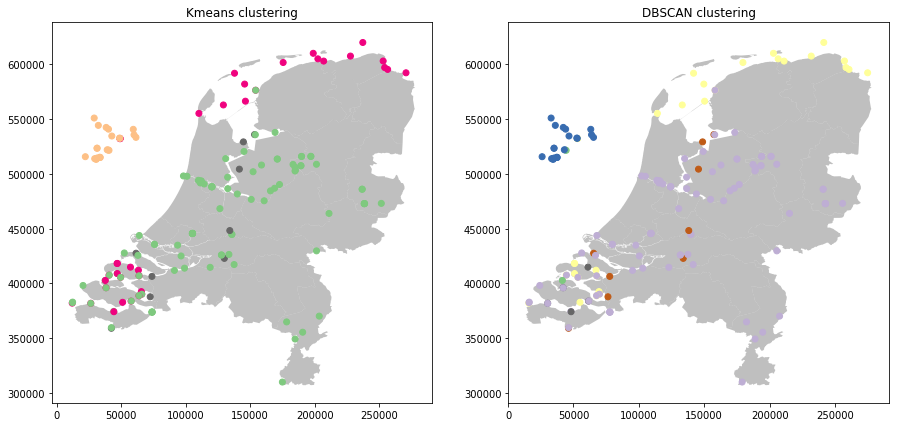

In [29]:
import geopandas as gpd
import matplotlib.pyplot as plt

nld = gpd.read_file("../doc/data/2018-Waterschappen/2018-Waterschappen.shp")

figure, ax = plt.subplots(1,2, figsize=(15,7))

nld.plot(figsize=(7,7), alpha=0.5, ax=ax[0], color='grey')
nld.plot(figsize=(7,7), alpha=0.5, ax=ax[1], color='grey')

ax[0].scatter(m_pivoted.x-2000, m_pivoted.y, cmap='Accent', c=m_pivoted.kmeans)
ax[0].set_title('Kmeans clustering')
ax[1].scatter(m_pivoted.x+2000, m_pivoted.y, cmap='Accent', c=m_pivoted.dbscan)
ax[1].set_title('DBSCAN clustering')

#m_pivoted.plot.scatter('x', 'y', c='kmeans', cmap='Accent', ax=ax)
import os
try:
    os.mkdir("img/andere/")
except BaseException as e:
    pass

figure.savefig("img/andere/clustering.png")

Vind de locaties op het land.

Text(0.5,1,'Kmeans clustering')

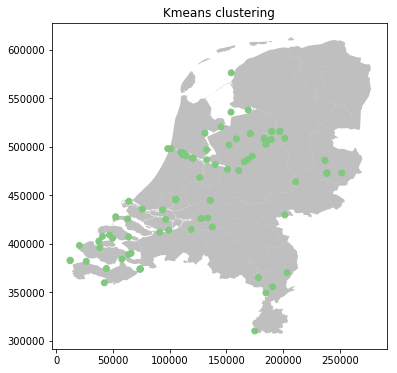

In [23]:
figure, ax = plt.subplots(figsize=(6,6))

nld.plot(figsize=(7,7), alpha=0.5, ax=ax, color='grey')

sel = m_pivoted[m_pivoted.kmeans==0]
ax.scatter(sel.x-2000, sel.y, cmap='Accent', c=sel.dbscan)
ax.set_title('Kmeans clustering')

#m_pivoted.plot.scatter('x', 'y', c='kmeans', cmap='Accent', ax=ax)

In [24]:
#Succ
land_loc_df = pd.DataFrame([list(el) for el in m_pivoted[m_pivoted.kmeans==0].index],
                           columns=['LOC','PLT:X', 'PLT:Y'])

land_loc_df.to_csv("../data/intermediate/land_loc.csv")

In [25]:
pd.DataFrame([[*i,db,km] for i,db,km in zip(m_pivoted.index, m_pivoted.dbscan, m_pivoted.kmeans)],
             columns = ['LOC','PLT:X','PLT:Y', 'dbscan', 'kmeans']).to_csv("../data/intermediate/loc_clustering.csv")

# Selecteer relevante parameters, kleur deze gebruikend de clustering.

In [26]:
pdf3['dbscan'] = [m_pivoted['dbscan'][pos] for pos in zip(pdf3.LOC, pdf3['PLT:X'], pdf3['PLT:Y'])]
pdf3['kmeans'] = [m_pivoted['kmeans'][pos] for pos in zip(pdf3.LOC, pdf3['PLT:X'], pdf3['PLT:Y'])]

In [27]:
pdf3.keys()

Index(['LOC', 'PLT:X', 'PLT:Y', 'DATUM:TIJD', 'ZS', 'GR', 'WINDSHD', 'WINDRTG',
       'SALNTT', 'GOLFHTE', 'Ql', 'ZICHT', 'HHTTL', 'GELDHD', 'dbscan',
       'kmeans'],
      dtype='object')

/home/jasper/.local/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/jasper/.local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/jasper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


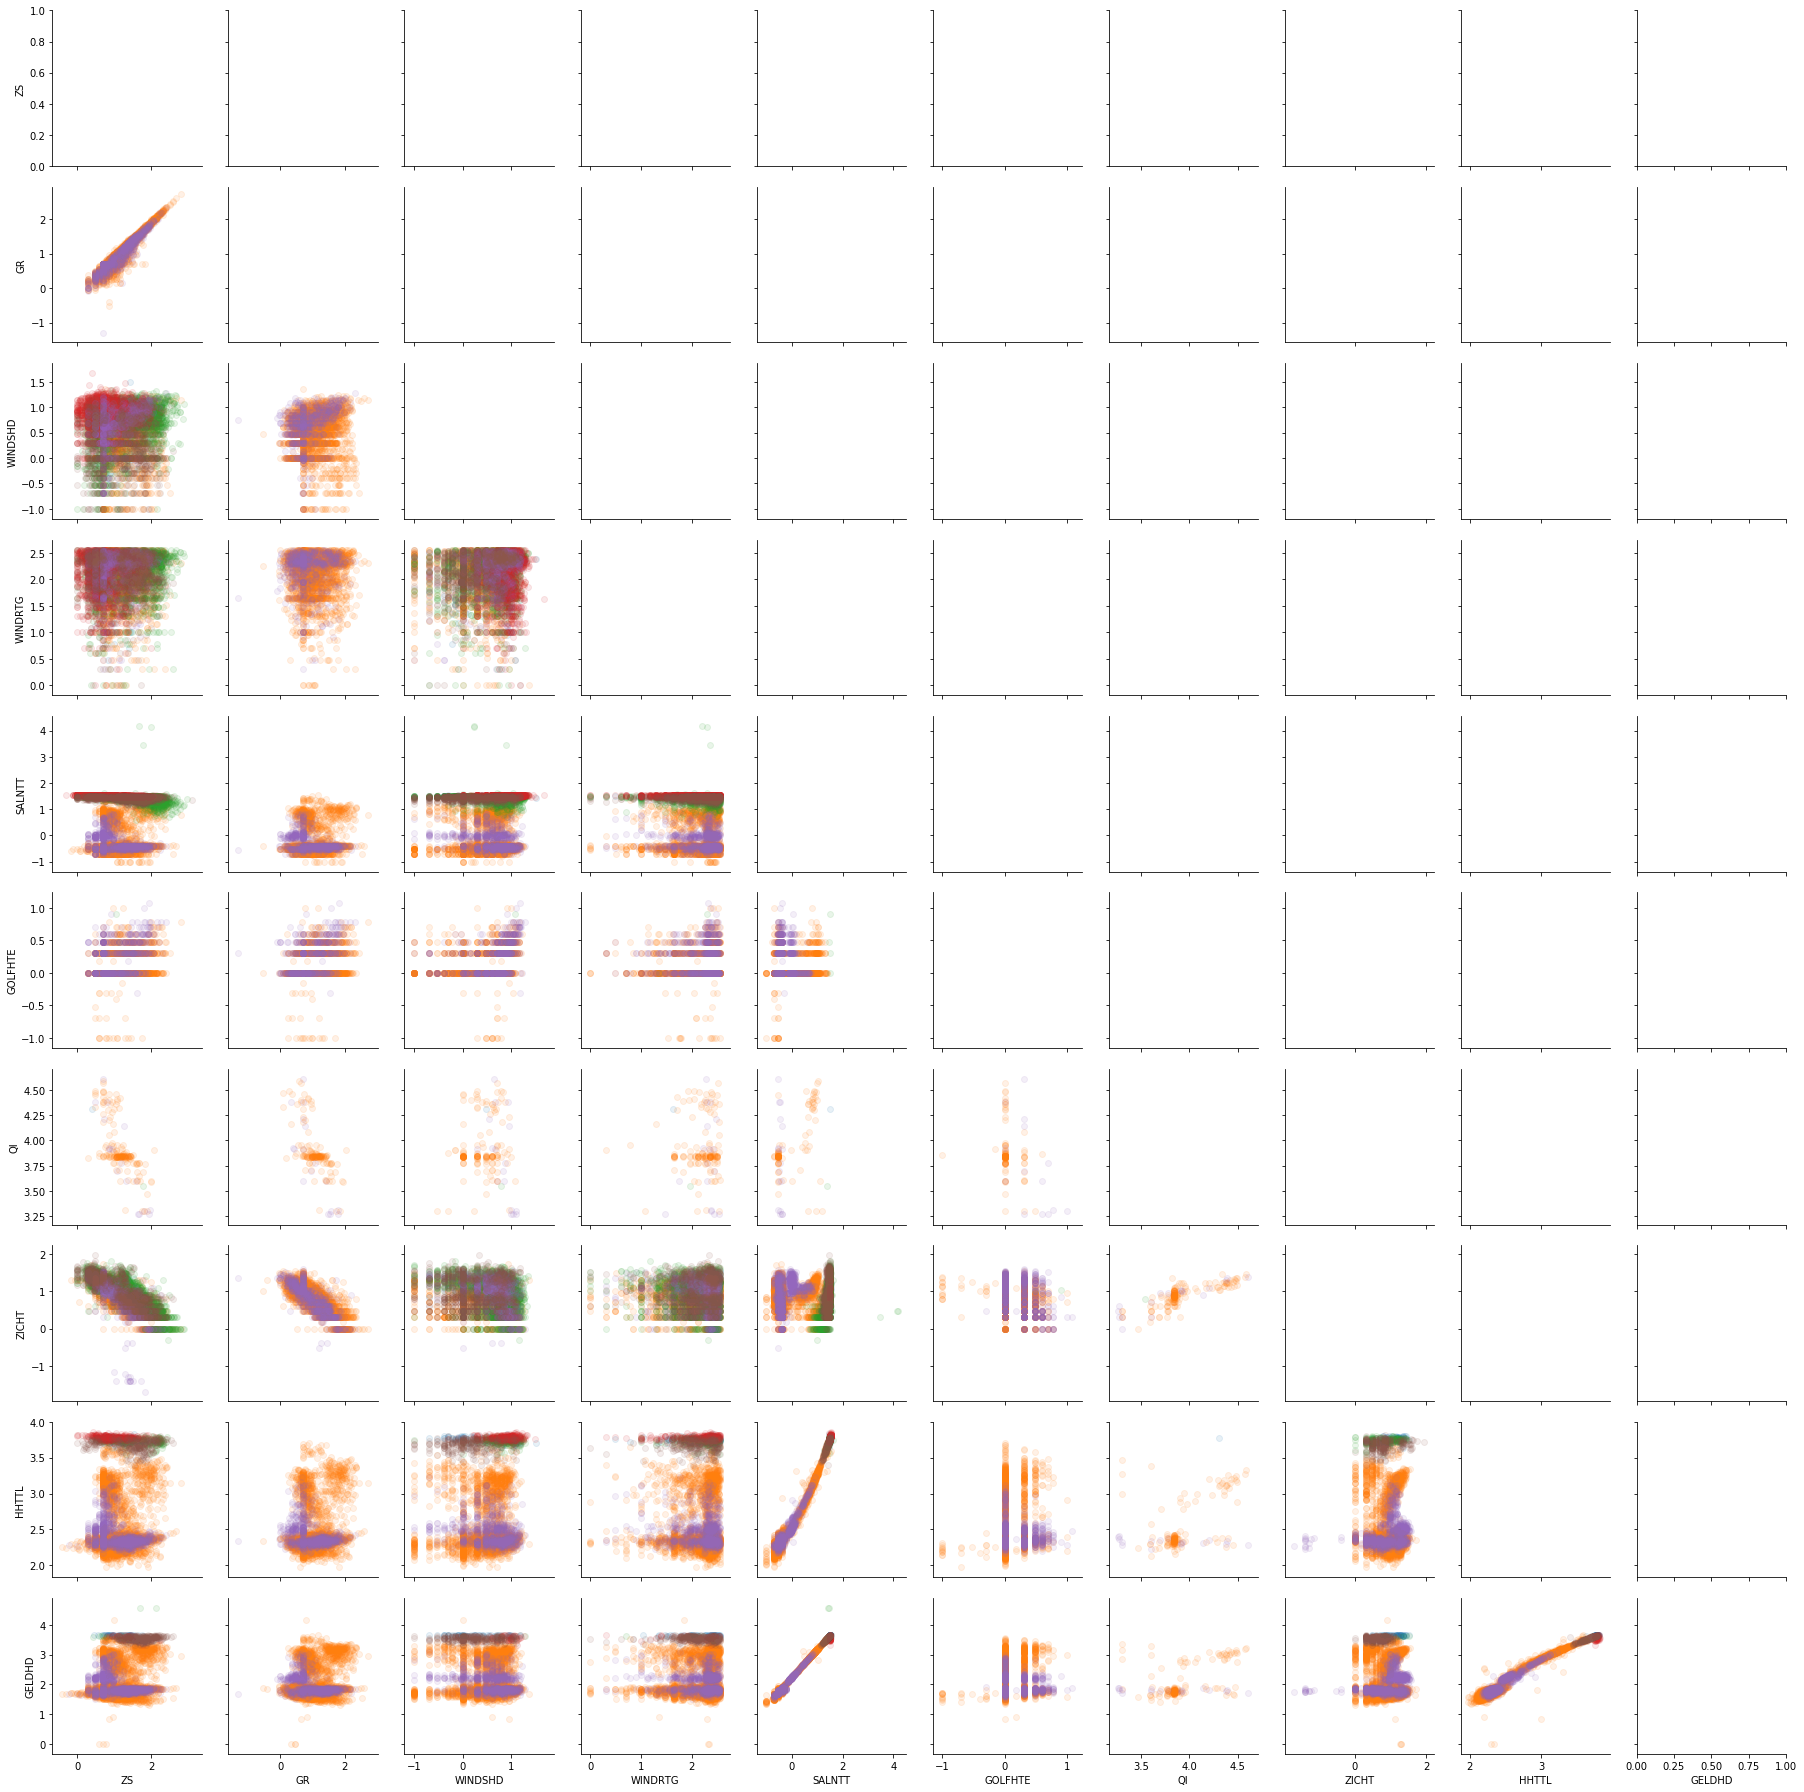

In [37]:
g = sns.PairGrid(pdf3, vars=['ZS','GR','WINDSHD', 'WINDRTG', 'SALNTT', 'GOLFHTE', 'Ql', 'ZICHT', 'HHTTL', 'GELDHD'],
                 hue='dbscan')

def no_whine_hist(*l, **kv):
    try:
        return plt.hist(*l, **kv)
    except:
        return

def log_scatter(x,y, *l, **kv):
    return plt.scatter(np.log10(x), np.log10(y), *l, alpha=0.1, **kv)

g.map_diag(no_whine_hist)
g.map_lower(log_scatter)

In [38]:
df['DATUM:TIJD'].min()

Timestamp('2006-01-02 06:30:00')

/home/jasper/.local/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/jasper/.local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/jasper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


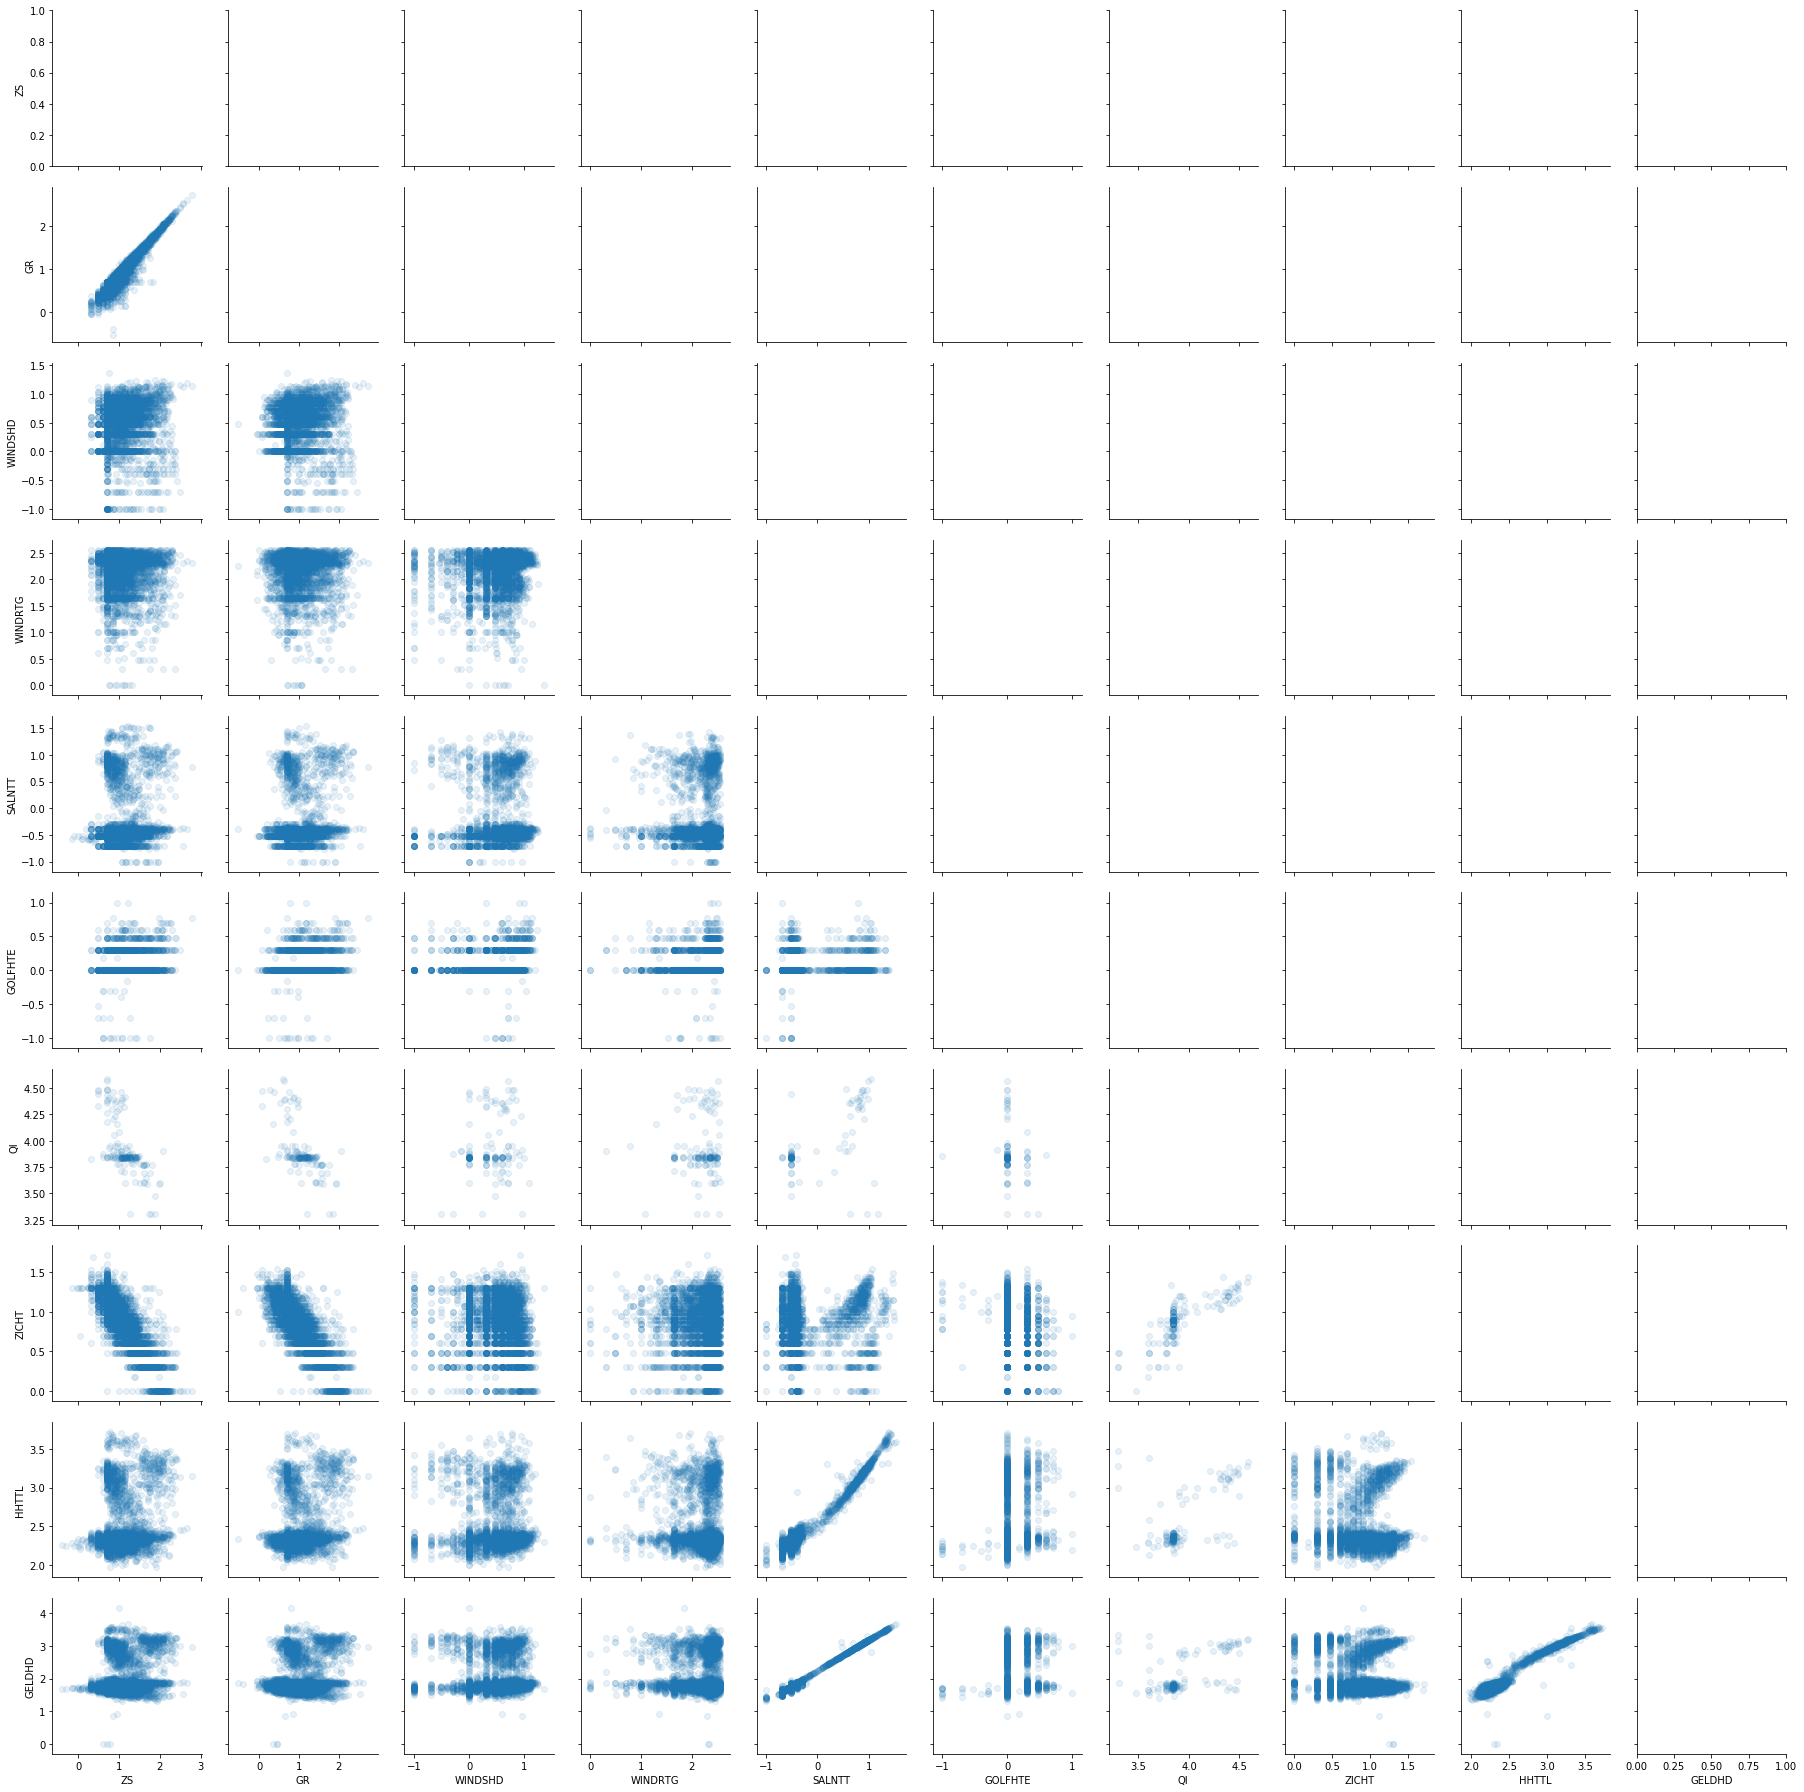

In [39]:
g = sns.PairGrid(pdf3[pdf3.kmeans==0],
                 vars=['ZS','GR','WINDSHD', 'WINDRTG', 'SALNTT', 'GOLFHTE', 'Ql', 'ZICHT', 'HHTTL', 'GELDHD'])
#g.add_legend # Or something
g.map_diag(no_whine_hist)
g.map_lower(log_scatter)

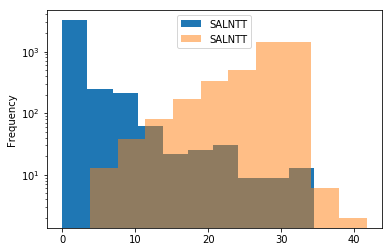

In [56]:
ax = pdf3[pdf3.kmeans==0].plot.hist(y='SALNTT',logy=True)
pdf3[(pdf3.kmeans==2) & (pdf3.SALNTT < 1000)].plot.hist(y='SALNTT',logy=True, ax=ax, alpha=0.5)

# Nog een keer... welke stoffen interessant?

### Via "theorie"
Kunnen nog meer correlaties vinden door vanuit ZS met correlaties buiten te werken.

Redenerend van wat er fysiek gebeurt.

* Verkeer
  + band materiaal etc?
  + 3NO + O3 → 3NO2 (`NO2`, `s_NO3NO2`,(`NO3`))
  + 3NO2 +3OH → 3HNO3
  + *TODO* hoe ging photodissociatie ding?
* Landbouw
  + HNO3 + NH3 → NH4 + NO3 (`NH4`)
  + Die boven ook relevant, [biologische processen](https://en.wikipedia.org/wiki/Nitrogen_cycle#Nitrification)
* Weer
  + Wind snelheid/richting, echter, tot nu toe niet veel gezien.
  + Debiet, wederom weinig gezien.
  + Neerslag, deze nog nauwelijks uit de data gehaalt.
  + Woestijnstof?

> De grootste massafractie in PM2.5 is tegenwoordig afkomstig van stikstof(mon)oxiden (NO) van vrachtverkeer, ozon uit fotochemische reactie en van ammoniak uit de bio-industrie: tezamen vormen deze gassen het ammoniumnitraat (NH4NO3). De chemische reactie van NO naar HNO3 verloopt volgens 3NO + O3 → 3NO2 en 3NO2 + 3OH → 3HNO3. De reactie naar NH4NO3 verloopt volgens HNO3 + NH3 → NH4NO3. 

### Via correlaties:

Gloeirest(GR,mg/l), Zwevende stof(ZS,mg/l), Particulair organisch koolstof(POC,mg/l), Totaal organisch koolstof(TOC,mg/l), Opgelost organisch koolstof(DOC,mg/l), Rest beta activiteit(RESTB,mBq/l)

## Welke locaties interesant?
Ik denk dat vooral landelijke locaties.

In [41]:
sel_loc_df = pd.read_csv("../data/intermediate/land_loc.csv").drop('Unnamed: 0', axis=1)

sel_loc_set = set(zip(sel_loc_df.LOC, sel_loc_df['PLT:X'], sel_loc_df['PLT:Y']))

sel_df = df[[((loc,x,y) in sel_loc_set) for loc,x,y in zip(df.LOC, df['PLT:X'], df['PLT:Y'])]]
len(sel_df), len(df)

(1346709, 2345295)

# Yearlies?

In [42]:
import datetime
year_seconds = 365.25*24*3600

def year_continuous(t, t_of=False):  # time in years.
    year = t.year
    return (0 if t_of else year) + (t.timestamp() - datetime.datetime(year,1,1).timestamp())/year_seconds

def over_year(indf, name, t_of=True):
    return pd.DataFrame({'fy':[year_continuous(d, t_of) for d in indf['DATUM:TIJD']], name:list(indf[name])})

import numpy as np
def yearly_hist(indf, name, ax=None, title=None, yearly=True, bins=24):  #TODO title.
    oy = over_year(indf, name, t_of=yearly)
    oy = oy[~oy[name].isna() & ~oy.fy.isna() & (oy[name]>0)]

    if title is None:
        ax.set_title(name)

    hd = ax.hist2d(oy.fy*(12 if yearly else 1), np.log10(oy[name]), bins=bins)

    # TODO y axis of plot is WRONG, remember we did a log10.
    fx,tx, fy,ty= hd[3].get_extent()
    ax.plot([fx+(tx-fx)*i/len(hd[0]) for i in range(len(hd[0]))],
            [fy+(ty-fy)*sum(n*i for i,n in enumerate(col))/sum(col)/len(col) for col in hd[0]], color='white')
    return hd

In [43]:
interests = [
    ('ZS', 'mg/l'), ('GR','mg/l'), ('RESTB', 'mBq/l'), ('Ql', 'l'),
    ('NO2', 'mg/l'), ('NH4', 'mg/l'), ('NO3', 'mg/l'),
    ('s_NO3NO2','mg/l'), ('HHTTL','mg/l'),
    ('V','ug/l')  # Vast niets
]
pdf4 = combine_interests(sel_df, interests)

Opmerking, y as logirithmisch om dingen makkelijker in beeld te krijgen, 0.3 is ongeveer een factor twee.

**TODO** per-vertikaal het gemiddelde?

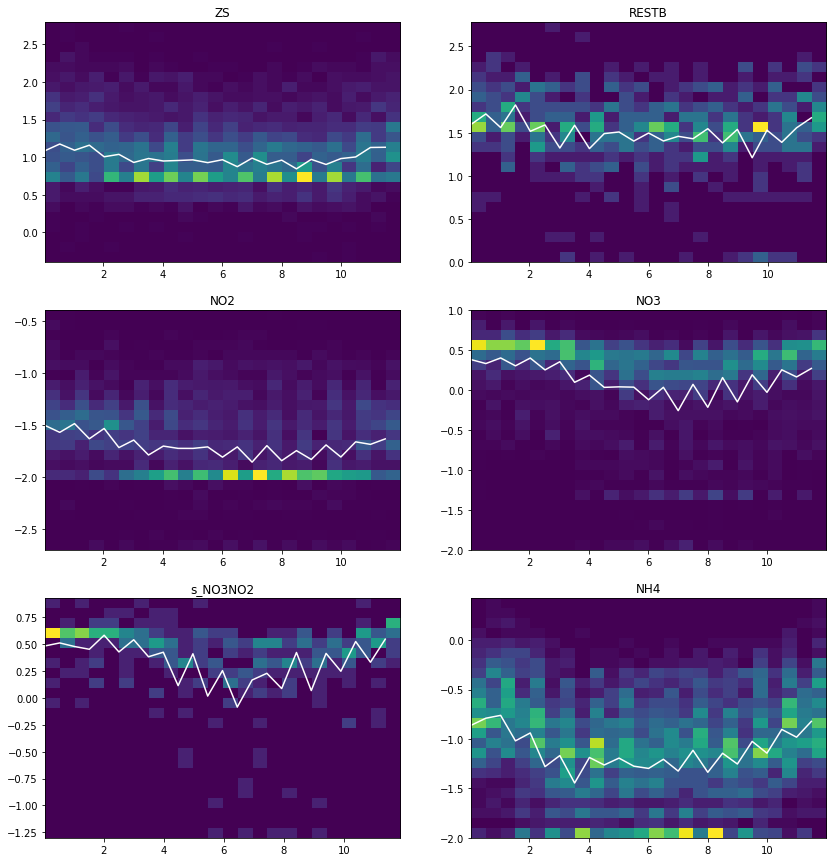

In [57]:
fig, ax = plt.subplots(3,2, figsize=(14,15))

yearly_hist(pdf4, 'ZS', ax=ax[0][0])
yearly_hist(pdf4, 'RESTB', ax=ax[0][1]) # Denk dat gewoon op die perioden meer gemeten. (en lichtelijk stof patroon)

yearly_hist(pdf4, 'NO2', ax=ax[1][0])
yearly_hist(pdf4, 'NO3', ax=ax[1][1]) 
yearly_hist(pdf4, 's_NO3NO2', ax=ax[2][0])
yearly_hist(pdf4, 'NH4', ax=ax[2][1])

fig.savefig("img/jaarlijks_1.png")

None

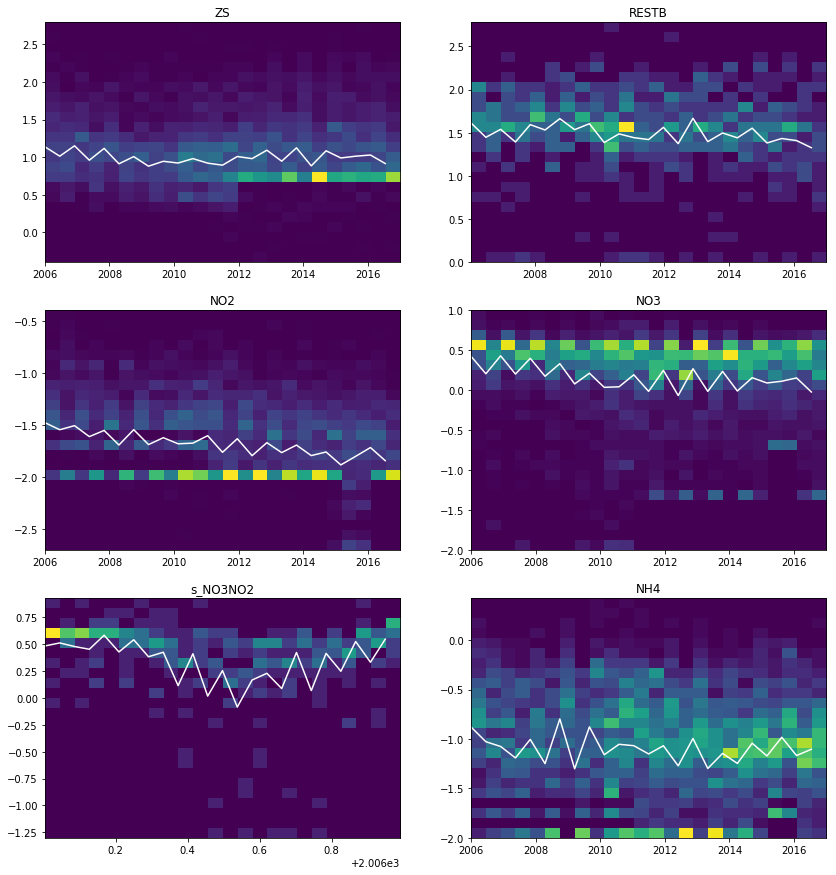

In [45]:
fig, ax = plt.subplots(3,2, figsize=(14,15))

yearly_hist(pdf4, 'ZS', ax=ax[0][0], yearly=False)
yearly_hist(pdf4, 'RESTB', ax=ax[0][1], yearly=False) # Denk dat gewoon op die perioden meer gemeten. (en lichtelijk stof patroon)

yearly_hist(pdf4, 'NO2', ax=ax[1][0], yearly=False)
yearly_hist(pdf4, 'NO3', ax=ax[1][1], yearly=False) 
yearly_hist(pdf4, 's_NO3NO2', ax=ax[2][0], yearly=False)
yearly_hist(pdf4, 'NH4', ax=ax[2][1], yearly=False)
None

In [46]:
", ".join(pdf4.LOC.unique())

'ALMLO, AMRKHVN2, AMSDM, BEERKNMDN, BELFBVN, BOVSS, BRAKL, BRIENOD, BROEKHVN, BUITHVN8, DOMBBSD, DRONTMDK0.4, EEFDBVN, EEMMDK23, EIJSDPTN, ENSDVTS, GENMDN, GOOIMMDN, GOUDVHVN, HAGSN, HAMMOT, HANSWGL, HARLGVHVN, HASST, HEEL, HEUSDBSVR, HOLLDMDSKWT, HOORNSHP, HOUTRHK, IJMDN1, KAMPN, KEIZVR, KETMWT, LELSHVN, LOBPTN, LODSGT, MAASSS, MARKGZE, NEDWT, NIEUWSS, NULDHK, OUDDBSD, PAMPOT, PUTTHK, RAMSDP, REVE, ROGGPGWT, SASVGT, SCHAARVODDL, SCHEELHK, SOELKKPDOT, STEILBK, STEVWT, TERNZBI20, VELWMMDN, VLISSGBISSVH, VROUWZD, VURN, WESTHVN2, WESTZN, WIELGN, WIENE, WISSKKE, WOLDWMDN, YERSKVWTPS, ZIERZDVL, ZIJKNLD1, ZIJKNLE2, ZIJPE, ZWAAN'

Jaarlijks NOX/NH4 goed te zien met `AMSDM`

/home/jasper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


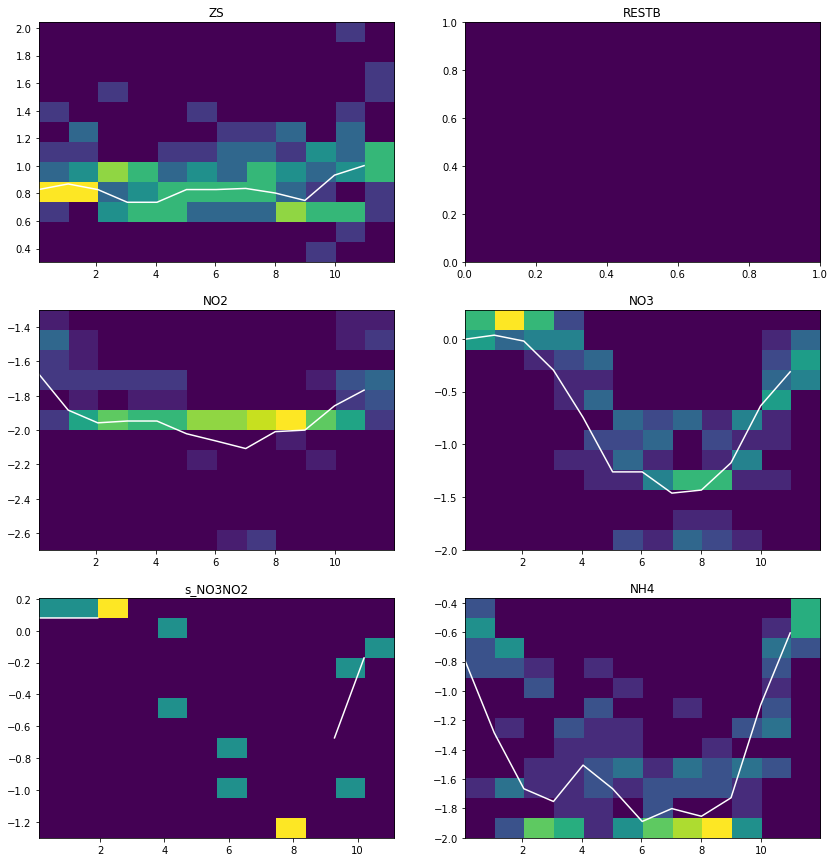

In [59]:
fig, ax = plt.subplots(3,2, figsize=(14,15))

spdf4 = pdf4[pdf4.LOC=='VELWMMDN']

yearly_hist(spdf4, 'ZS', ax=ax[0][0], bins=12)
yearly_hist(spdf4, 'RESTB', ax=ax[0][1], bins=12) # Denk dat gewoon op die perioden meer gemeten. (en lichtelijk stof patroon)

yearly_hist(spdf4, 'NO2', ax=ax[1][0], bins=12)
yearly_hist(spdf4, 'NO3', ax=ax[1][1], bins=12) 
yearly_hist(spdf4, 's_NO3NO2', ax=ax[2][0], bins=12)
yearly_hist(spdf4, 'NH4', ax=ax[2][1], bins=12)

fig.savefig("img/jaarlijks_VELWMMDN.png")
None

Hmm.. weinig patroon in debiet?

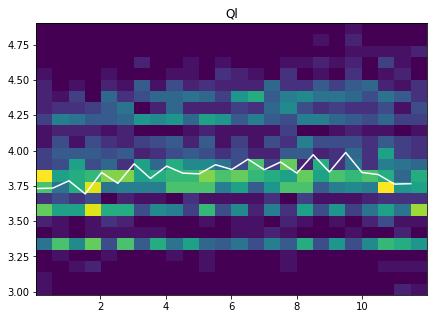

In [48]:
fig, ax = plt.subplots(figsize=(7,5))
yearly_hist(pdf4, 'Ql', ax=ax)
None

-------------------------
# Stuff

/home/jasper/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/jasper/.local/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/jasper/.local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/jasper/.local/lib/python3.6/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/jasper/.local/lib/python3.6/site-packages/matplotlib/contour.py:1481: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/jasper/.local/lib/python3.6/site-packages/matplotlib/contour.py:1169: Runt

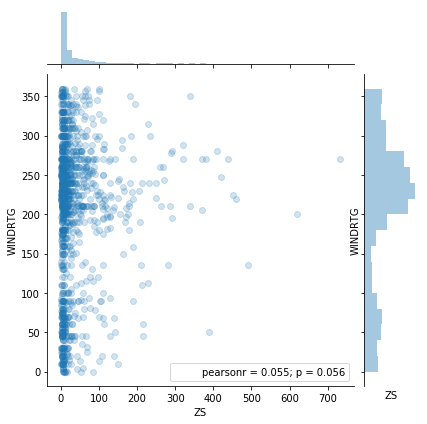

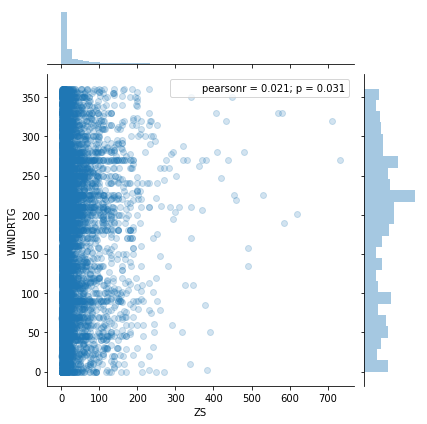

In [49]:
sel = pdf2[pdf2.WINDSHD>10]
g = sns.jointplot(sel.ZS, sel.WINDRTG, alpha=0.2)

sns.kdeplot(sel.ZS, sel.WINDRTG)
sns.jointplot(pdf2.ZS, pdf2.WINDRTG, alpha=0.2)

# Ongerelateerd, saliniteit
Saliniteit en hardheid strak gerelateerd.(merk meeste data in hoek, daarom loglog)

**TODO** in relatie, check `pH`, geleidendheid. `('GELDHD', 'mS/m')`

/home/jasper/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


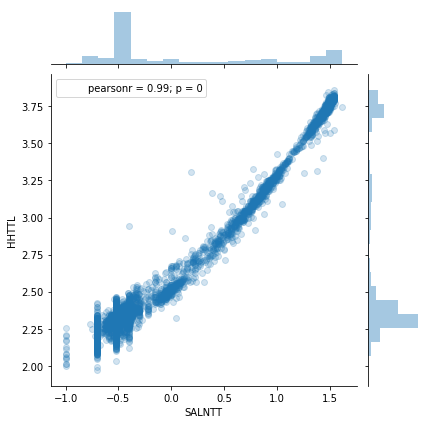

In [50]:
import seaborn as sns

sel = pdf3[pdf3.SALNTT>0]
sns.jointplot(np.log10(sel.SALNTT), np.log10(sel.HHTTL), alpha=0.2)

Deze ziet er vreemd uit, meerdere gevallen?

/home/jasper/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


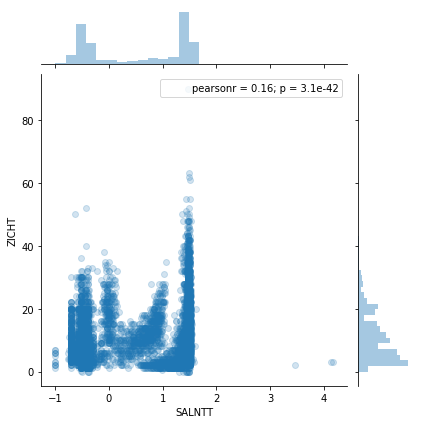

In [51]:
sel = pdf3[pdf3.SALNTT>0]
sns.jointplot(np.log10(sel.SALNTT), sel.ZICHT, alpha=0.2)

/home/jasper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/home/jasper/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


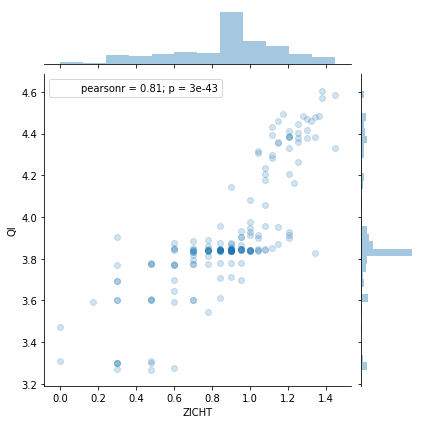

In [52]:
sns.jointplot(np.log10(pdf3.ZICHT), np.log10(pdf3.Ql), alpha=0.2)

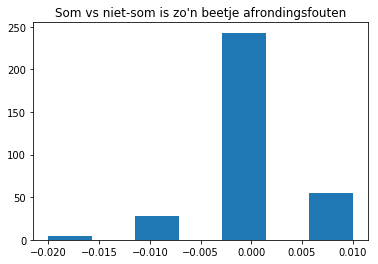

In [53]:
fig,ax = plt.subplots()
ax.hist([x for x in (pdf4.NO2 + pdf4.NO3-pdf4.s_NO3NO2).dropna() if x>-0.1], bins=7)
ax.set_title("Som vs niet-som is zo'n beetje afrondingsfouten")
None

In [54]:
pd.read_csv("../data/knmi_desc.csv")

name                                               desc
0   YYYYMMDD                   Date (YYYY=year MM=month DD=day)
1      DDVEC  Vector mean wind direction in degrees (360=nor...
2      FHVEC                 Vector mean windspeed (in 0.1 m/s)
3         FG                  Daily mean windspeed (in 0.1 m/s)
4        FHX         Maximum hourly mean windspeed (in 0.1 m/s)
5       FHXH          Hourly division in which FHX was measured
6        FHN         Minimum hourly mean windspeed (in 0.1 m/s)
7       FHNH          Hourly division in which FHN was measured
8        FXX                     Maximum wind gust (in 0.1 m/s)
9       FXXH          Hourly division in which FXX was measured
10        TG    Daily mean temperature in (0.1 degrees Celsius)
11        TN       Minimum temperature (in 0.1 degrees Celsius)
12       TNH           Hourly division in which TN was measured
13        TX       Maximum temperature (in 0.1 degrees Celsius)
14       TXH           Hourly division in which TX was measured
15      T10N  Minimum temperature at 10 cm above surface (in...
16     T10NH       6-hourly division in which T10N was measured
17        SQ  Sunshine duration (in 0.1 hour) calculated fro...
18        SP  Percentage of maximum potential sunshine duration
19         Q                        Global radiation (in J/cm2)
20        DR               Precipitation duration (in 0.1 hour)
21        RH  Daily precipitation amount (in 0.1 mm) (-1 for...
22       RHX  Maximum hourly precipitation amount (in 0.1 mm...
23      RHXH          Hourly division in which RHX was measured
24      EV24  Potential evapotranspiration (Makkink) (in 0.1...
25        PG  Daily mean sea level pressure (in 0.1 hPa) cal...
26        PX     Maximum hourly sea level pressure (in 0.1 hPa)
27       PXH           Hourly division in which PX was measured
28        PN     Minimum hourly sea level pressure (in 0.1 hPa)
29       PNH           Hourly division in which PN was measured
30       VVN                                 Minimum visibility
31      VVNH          Hourly division in which VVN was measured
32       VVX                                 Maximum visibility
33      VVXH          Hourly division in which VVX was measured
34        NG  Mean daily cloud cover (in octants, 9=sky invi...
35        UG  Daily mean relative atmospheric humidity (in p...
36        UX  Maximum relative atmospheric humidity (in perc...
37       UXH           Hourly division in which UX was measured
38        UN  Minimum relative atmospheric humidity (in perc...
39       UNH           Hourly division in which UN was measured

In [55]:
knmi_df = pd.read_csv("../data/knmi_data.csv")

/usr/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,18,19,20,21,22,23,24,25,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
